In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns

%matplotlib inline


In [2]:
jtplot.style(theme='monokai')

# Import data
Remember! I'm only using the working lyrics on day one as I am still importing lyric data

In [3]:
chart_df = pd.read_csv('../data/all_charts.csv')
lyrics_df = pd.read_csv('../data/lyrics_second_pass.csv')
spotify_df = pd.read_csv('../data/spotify_data.csv')

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
chart_df.head(2)

,Unnamed: 0,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,...,art_6,art_7,art_8,art_9,art_10,art_11,art_12,art_13,art_14,art_15
0,0,1958-08-16,Poor Little Fool,Ricky Nelson,1,1,11,1,0,33FPsMEl3UwpytDuyf9VYq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1958-08-16,Nel Blu Dipinto Di Blu (VolarÃÂ©),Domenico Modugno,1,54,16,2,+52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
lyrics_df.head(2)

,Song,Artist,spotifyID,Lyrics,Source
0,poor little fool,ricky nelson,33FPsMEl3UwpytDuyf9VYq,i used to play around with hearts that hastene...,1.0
1,nel blu dipinto di blu volar~a^a,domenico modugno,NaN,not set yet,NaN


In [6]:
spotify_df.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_uri,duration_ms,time_signature,key_mode
0,0.549,0.336,C,-11.669,major,0.0290,0.6520,0.000,0.134,0.802,154.958,33FPsMEl3UwpytDuyf9VYq,153933.0,4,C major
1,0.696,0.743,C#,-6.623,major,0.0439,0.0836,0.197,0.119,0.776,137.276,0nG4SbrAONIFLIwQqegooj,138747.0,4,C# major


In [7]:
# keep relevant columns
# chart_df.columns.tolist()

chart_cols = ['chartDate', 'title', 'artist', 'peakPos', 'lastPos', 'weeks', 'rank', 'change','spotifyID']
chart_df = chart_df[chart_cols]

In [8]:
# combine chart_df with spotify data
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')

In [9]:
df = df.drop_duplicates()

In [10]:
# break out major minor key
df['maj_minor'] = df['key_mode'].str.split(' ', 1).str[1]

In [11]:
chart_len = chart_df.shape[0]
spot_len = df.shape[0]
print('chart_songs: ' + str(chart_len), 
     '\nspotify_songs: ' + str(spot_len),
     '\npercent_overlap: ' + str(round((spot_len / chart_len)*100, 2)) + '%')

chart_songs: 304643 
spotify_songs: 258820 
percent_overlap: 84.96%


In [12]:
# combine df with lyric data
# todo deal with ~ 100 dups
# df = pd.merge(df, lyrics_df, on='spotifyID', how='left')

In [13]:
# convert to datetime
df['chartDate'] = pd.to_datetime(df[('chartDate')])

In [14]:
df['year'] = df['chartDate'].dt.year

In [15]:
df['month'] = df['chartDate'].dt.month

In [16]:
df[['valence', 'energy']].head(5)

,valence,energy
0,0.802,0.336
2,0.802,0.336
4,0.802,0.336
6,0.802,0.336
8,0.802,0.336


Check matchups

<function matplotlib.pyplot.show>

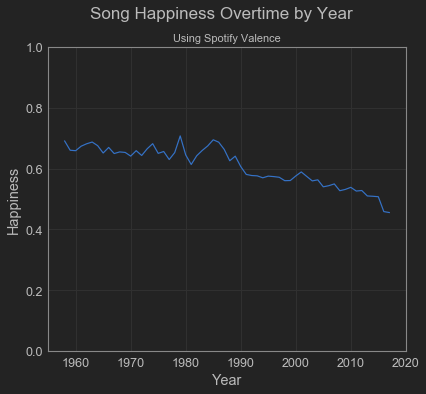

In [17]:
by_year_df = df.groupby('year')['valence','liveness'].mean().reset_index()

# sns.barplot(x = 'year', y = 'valence', data = df)

plt.plot(by_year_df['year'], by_year_df['valence'])
plt.suptitle('Song Happiness Overtime by Year', fontsize = 17)
plt.title('Using Spotify Valence', fontsize = 11)
plt.xlabel('Year')
plt.ylabel('Happiness')
plt.ylim(0, 1)
plt.show

<function matplotlib.pyplot.show>

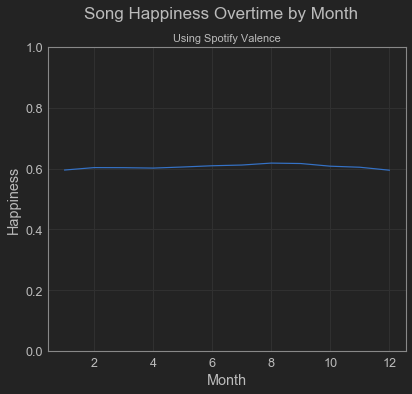

In [18]:
by_month_df = df.groupby('month')['valence','liveness'].mean().reset_index()

plt.plot(by_month_df['month'], by_month_df['valence'])
plt.suptitle('Song Happiness Overtime by Month', fontsize = 17)
plt.title('Using Spotify Valence', fontsize = 11)
plt.xlabel('Month')
plt.ylabel('Happiness')
plt.ylim(0, 1)
plt.show

# Explore text 

In [19]:
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()]

In [20]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23774 entries, 0 to 34419
Data columns (total 5 columns):
Song         23774 non-null object
Artist       23774 non-null object
spotifyID    20233 non-null object
Lyrics       23774 non-null object
Source       23774 non-null float64
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [21]:
# from spacy.tokenizer import Tokenizer
# tokenizer = Tokenizer(nlp.vocab)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

In [23]:
word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()

In [24]:
word_counts.columns = ['word', 'count']

In [25]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
top_words

,word,count
152,love,67254
343,im,59816
154,dont,46610
109,know,43294
77,like,39185
98,just,37936
8,oh,35941
160,baby,35642
40,want,33225
74,got,32930


In [26]:
word_counts.sort_values('count', ascending = False).tail()

,word,count
2707,bites,41
3756,ruff,41
3736,unfair,41
1495,worthy,41
558,fantastic,41


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

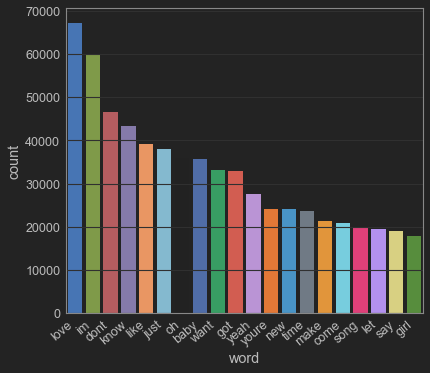

In [27]:
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xticks(rotation=40, ha = 'right')

In [28]:
# import spacy 
# nlp = spacy.load(“en”)
# https://www.analyticsvidhya.com/blog/2017/04/natural-language-processing-made-easy-using-spacy-%E2%80%8Bin-python/

In [29]:
from textblob import TextBlob

In [30]:
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run

In [31]:
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # convert to 0 - 1 scale
# lyrics_df['subjectivity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.subjectivity)

In [32]:
lyrics_df.head()

,Song,Artist,spotifyID,Lyrics,Source,tb_obj,polarity
0,poor little fool,ricky nelson,33FPsMEl3UwpytDuyf9VYq,i used to play around with hearts that hastene...,1.0,"(i, , u, s, e, d, , t, o, , p, l, a, y, , ...",0.442305
2,patricia,perez prado and his orchestra,0nG4SbrAONIFLIwQqegooj,kiss her and your lips will always want patric...,2.0,"(k, i, s, s, , h, e, r, , a, n, d, , y, o, ...",0.610000
3,splish splash,bobby darin,6NCPbpsr2N4w6YIZkpq6jx,splish splash i was taking a bath long about a...,1.0,"(s, p, l, i, s, h, , s, p, l, a, s, h, , i, ...",0.641883
4,when,kalin twins,52l2PCOwU2n2zfTlc0pEov,when when you smile when you smile at me well ...,2.0,"(w, h, e, n, , w, h, e, n, , y, o, u, , s, ...",0.689021
5,my true love,jack scott,2urRqmAFhjZKo8Z6sEGzEv,i prayed to the lord to send me a love he sent...,1.0,"(i, , p, r, a, y, e, d, , t, o, , t, h, e, ...",0.678234


## Create df_w_l

In [33]:
df_w_l = pd.merge(df, lyrics_df, on = 'spotifyID', how = 'inner')

In [34]:
from sklearn.metrics.pairwise import euclidean_distances

# create spotify coordinate
coord = df_w_l['coord'] =[[df_w_l['valence'].iloc[i], df_w_l['energy'].iloc[i]] for i in range(df_w_l.shape[0])]
df_w_l['happy_dist'] = euclidean_distances(coord, [[0, 0]])

In [35]:
df_w_l['happy_index'] = (df_w_l['happy_dist'] + df_w_l['polarity'])/2
# df_w_l[]

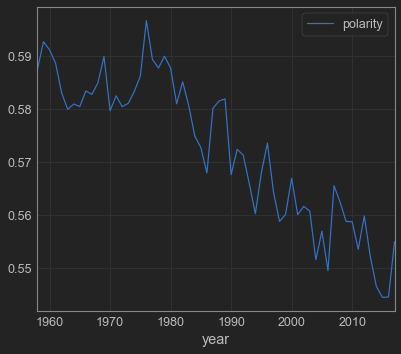

In [36]:
df_w_l.groupby('year')['polarity'].mean().reset_index().plot('year', 'polarity')

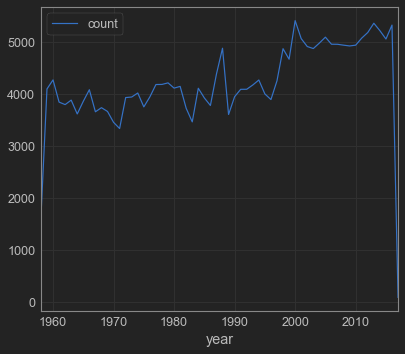

In [37]:
df_w_l.groupby('year')['spotifyID'].count().reset_index(name = 'count').plot('year', 'count')

In [39]:
df_w_l['rank_weight'] = 101 - df_w_l['rank'] 

In [40]:
wa_group = df_w_l.groupby("year").apply(lambda x: np.average(x['polarity'], weights=x['rank_weight'])).reset_index(name = 'weighted_mean')
uw_group = df_w_l.groupby("year")['polarity'].mean().reset_index(name = 'mean')

grouped_avgs = pd.merge(wa_group, uw_group, on = 'year', how = 'inner')
grouped_avgs['avg_delta'] = grouped_avgs['mean'] - grouped_avgs['weighted_mean']

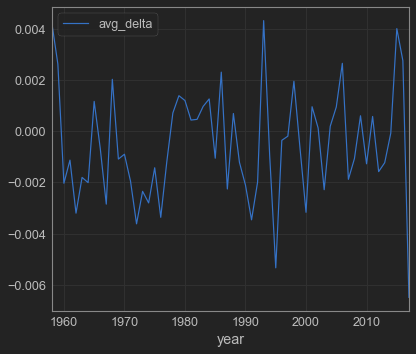

In [41]:
grouped_avgs.plot('year', 'avg_delta')

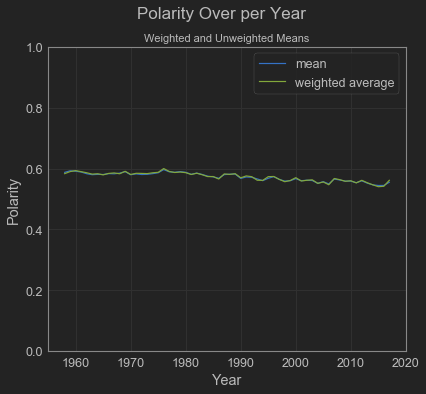

In [54]:
# grouped_avgs.plot('year', 'weighted_avg')
# grouped_avgs.plot('year', 'mean')

plt.plot(grouped_avgs['year'], 
         grouped_avgs['mean'], 
         label = 'mean')
plt.plot(grouped_avgs['year'], 
         grouped_avgs['weighted_mean'],
         label = 'weighted average')
plt.suptitle('Polarity Over per Year', fontsize = 17)
plt.title('Weighted and Unweighted Means', fontsize = 11)
plt.xlabel('Year')
plt.ylabel('Polarity')
plt.ylim(0, 1)
plt.legend()

In [ ]:
plt.plot(grouped_avgs['year'], 
         grouped_avgs['mean'], 
         label = 'mean')
plt.plot(grouped_avgs['year'], 
         grouped_avgs['weighted_mean'],
         label = 'weighted average')
plt.suptitle('Polarity Over per Year', fontsize = 17)
plt.title('Weighted and Unweighted Means', fontsize = 11)
plt.xlabel('Year')
plt.ylabel('Polarity')
plt.ylim(0, 1)
plt.legend()

### Happiest Song

In [43]:
df_w_l.columns.tolist()

['chartDate',
 'title',
 'artist',
 'peakPos',
 'lastPos',
 'weeks',
 'rank',
 'change',
 'spotifyID',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'track_uri',
 'duration_ms',
 'time_signature',
 'key_mode',
 'maj_minor',
 'year',
 'month',
 'Song',
 'Artist',
 'Lyrics',
 'Source',
 'tb_obj',
 'polarity',
 'coord',
 'happy_dist',
 'happy_index',
 'rank_weight']

In [46]:
hot_features = ['chartDate',
                'title',
                'artist',
                'peakPos',
                'weeks',
                'change',
                'spotifyID',
                'polarity',
                'valence',
                'danceability',
                'energy',
                'loudness',
                'speechiness',
                'acousticness',
                'instrumentalness',
                'liveness',
                'maj_minor',
                'tempo']

In [47]:
df_w_l.sort_values('polarity', ascending = False).head(50).drop_duplicates(subset = ['title', 'artist', 'peakPos']).head(5)[hot_features]

,chartDate,title,artist,peakPos,weeks,change,spotifyID,polarity,valence,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,maj_minor,tempo
202148,2006-12-09,Greatest Time Of Year,Aly & AJ,96,1,New,3ufSi9aFa7Pec9jGa5wC7f,1.000,0.811,0.513,0.834,-5.007,0.0448,0.000325,0.000000,0.6660,major,150.961
15878,1962-05-26,Cindy's Birthday,Johnny Crawford,8,13,+14,07oNtZHxFVheLRQFGNrlNA,0.950,0.708,0.610,0.316,-12.600,0.0335,0.755000,0.000218,0.1210,major,110.000
8028,1960-07-23,Finger Poppin' Time,Hank Ballard And The Midnighters,7,26,+25,3jTNxvot7QvKRycomnKlCE,0.925,0.914,0.675,0.604,-7.535,0.0251,0.147000,0.000005,0.0363,major,79.789
37689,1968-02-10,We Can Fly,The Cowsills,21,9,+13,6OqBZSt4V2coMVJx4PEFk7,0.900,0.558,0.380,0.530,-11.526,0.0459,0.623000,0.000001,0.1560,minor,143.529
26260,1965-02-13,Fly Me To The Moon,LaVern Baker,84,2,Re-Entry,7vGcqsWwXcsBo3C0rWhktb,0.900,0.481,0.487,0.278,-8.663,0.0272,0.810000,0.003140,0.2730,minor,82.136


In [48]:
df_w_l.sort_values('valence', ascending = False).head(50).drop_duplicates(subset = ['title', 'artist', 'peakPos']).head(5)[hot_features]

,chartDate,title,artist,peakPos,weeks,change,spotifyID,polarity,valence,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,maj_minor,tempo
28178,1965-09-11,It's The Same Old Song,Four Tops,5,9,-7,3A5EnavJmmUTAgUWQkaxnP,0.568608,0.990,0.729,0.768,-6.915,0.0307,0.22400,0.000000,0.0349,minor,125.812
12308,1961-06-24,I'm Gonna Knock On Your Door,Eddie Hodges,12,13,Re-Entry,4s0rm7fy4J67YshivPbMv5,0.607184,0.989,0.749,0.822,-8.637,0.0329,0.77200,0.008100,0.0688,major,126.891
70020,1976-08-07,Hideaway,John Sebastian,95,2,+1,51NG9ouCDAfQSRx9buc1EV,0.534722,0.988,0.791,0.710,-12.425,0.0346,0.08500,0.000185,0.0788,major,127.598
66551,1975-12-13,Low Rider,War,7,15,-11,4DagZHq2NslXErKEnAhp92,0.483009,0.986,0.807,0.536,-14.431,0.0608,0.07570,0.612000,0.0602,major,138.894
97670,1983-06-04,She Works Hard For The Money,Donna Summer,3,21,+12,3FlOciKDqFlTMPeC7t92Qy,0.492045,0.986,0.765,0.639,-12.963,0.0382,0.00669,0.012200,0.0798,minor,136.495


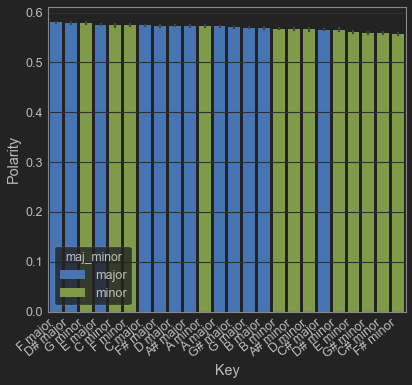

In [49]:
key_order = df_w_l.groupby('key_mode')['polarity'].mean().reset_index(name = 'mean').sort_values('mean', ascending = False)['key_mode'].tolist()

sns.barplot(data = df_w_l, 
            x = 'key_mode', 
            y = 'polarity', 
            order = key_order, hue="maj_minor", dodge = False)
plt.xticks(rotation=40, ha = 'right')
plt.xlabel('Key')
plt.ylabel('Polarity')
plt.show()

In [50]:
key_year_group = df_w_l.groupby([(df_w_l.chartDate.dt.year//10)*10, 'key_mode'])[['polarity']]\
    .count()\
    .reset_index()\
    .rename(index=str, columns={"chartDate": "Decade", "key_mode": "Key", "polarity": "Count"})

key_year_group = key_year_group[key_year_group['Decade'] != 1950]
key_year_group.head()

,Decade,Key,Count
24,1960,A major,3038
25,1960,A minor,588
26,1960,A# major,2699
27,1960,A# minor,390
28,1960,B major,1168


In [51]:
key_year_group.Key.unique()

array(['A major', 'A minor', 'A# major', 'A# minor', 'B major', 'B minor',
       'C major', 'C minor', 'C# major', 'C# minor', 'D major', 'D minor',
       'D# major', 'D# minor', 'E major', 'E minor', 'F major', 'F minor',
       'F# major', 'F# minor', 'G major', 'G minor', 'G# major', 'G# minor'], dtype=object)

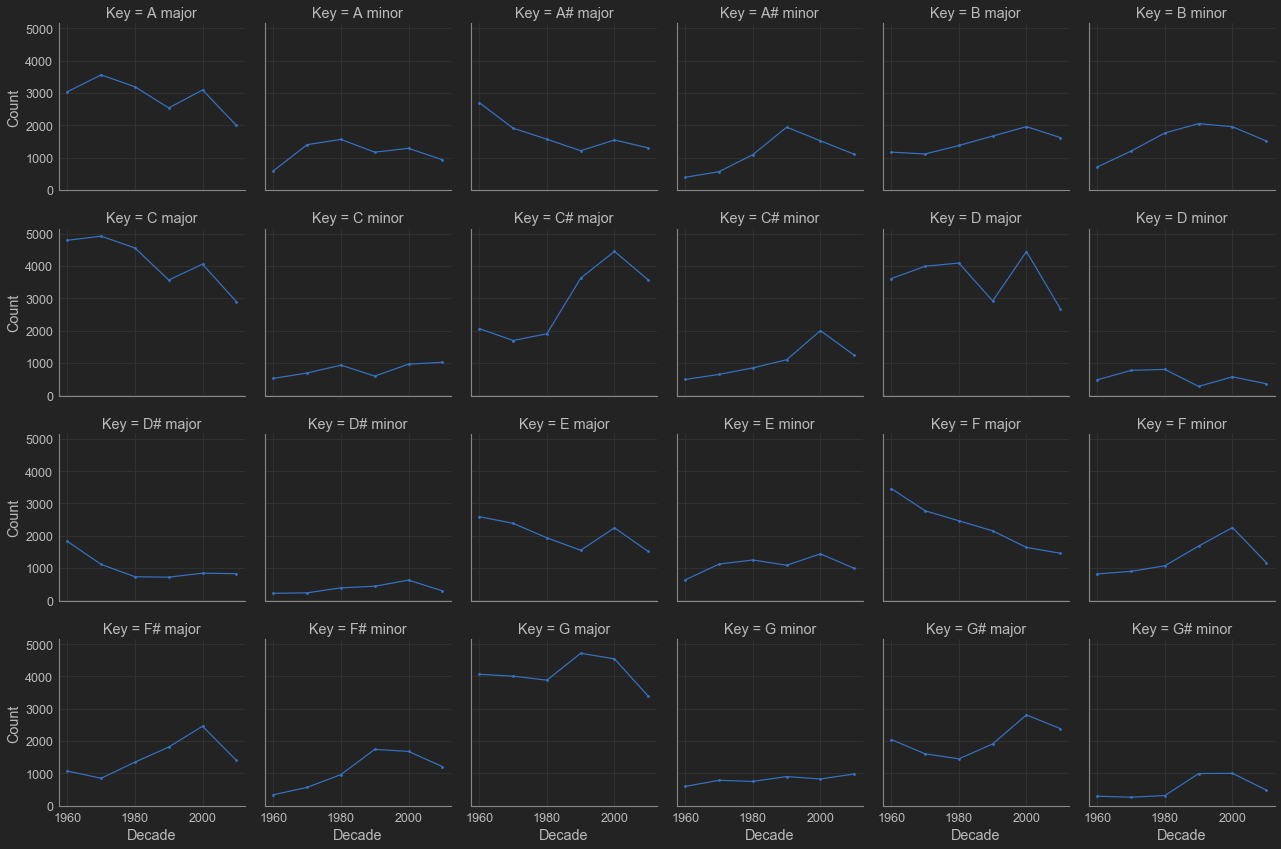

In [52]:
g = sns.FacetGrid(key_year_group, col="Key", col_wrap=6) # , size=1.5
g = g.map(plt.plot, "Decade", "Count", marker=".")

In [53]:
df_w_l[df_w_l['polarity'] < 0]

,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,danceability,...,Song,Artist,Lyrics,Source,tb_obj,polarity,coord,happy_dist,happy_index,rank_weight
